# Import packages and define global variables and functions

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
from matplotlib.patches import Ellipse
import statsmodels.stats.multitest as smm
from sklearn import metrics
import itertools

In [2]:
os.chdir("/Users/shahdelnaggar/Desktop/korem-lab/south-africa-ESCC/ESCC_microbiome_16S_analysis")

In [19]:
def sdi(counts):
    """ Given a list of counts, returns the Shannon Diversity Index (SDI) """
    from math import log as ln
    def p(n, N):
        """ Relative abundance """
        if n == 0:
            return 0
        else:
            return (float(n) / N) * ln(float(n) / N)   
    N = sum(counts)
    return -sum(p(n, N) for n in counts if n != 0)

def taxa_boxplot(feature_table,taxa,save=False,log=False):
    cancer = [int("CESCC" in sample_id) for sample_id in feature_table.index]
    my_pal = {0: "#00AEEF", 1: "#BE1E2D"}
    sns.set_theme(style="white", palette=None)
    sns.set_style("ticks")
    fig, ax = plt.subplots(figsize=(2, 3))
    if log: 
        ax.set_ylim(1e-4,2)
        ax.set_yscale("log")
    sns.boxplot(x=cancer, y=feature_table[taxa] + 1e-4,hue = cancer, fliersize=2,linewidth=1.4,palette=my_pal,legend=None) # .apply(lambda x:np.log10(x + 1e-4))
    sns.swarmplot(x=cancer, y=feature_table[taxa] + 1e-4,color="black",s=4) #.apply(lambda x:np.log10(x + 1e-4))
    ax.set_ylabel("Relative Abundance") #log10(Relative Abundance)
    ax.set_xlabel("")
    ax.set_title(f"{taxa}", size=12, fontweight='bold')
    ax.tick_params(labelsize=12,bottom=False)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Control', 'ESCC'], size=12)
    if save: 
        plt.savefig(f'figure')

In [3]:
feature_table = pd.read_csv("data/feature_table_decontaminated.csv",index_col=0).T
rarefied_table = pd.read_csv("data/feature_table_filtered_rarefied.csv",index_col=0).T # taxa in at least 5 samples, total count of 20, rarefied to minimum sampling depth (9700 reads)
taxonomy = pd.read_csv("data/homd-taxonomy.csv", index_col=0)

In [4]:
feature_ra = feature_table.div(feature_table.sum(axis=1),axis=0)
feature_ra.sort_index(inplace=True)

num_samples = 5
feature_table_filtered = feature_table.loc[:, (feature_table > 0).sum(axis = 0) >= num_samples]
feature_ra_filtered = feature_table_filtered.div(feature_table_filtered.sum(axis=1),axis=0)
feature_ra_filtered.sort_index(inplace=True)

# Diversity metrics

## Fig 1a. Alpha Diversity 

/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 5.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/3_/1cj9ly452_bgpshkny7139pr0000gn/T/ipykernel_1108/1170065213.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Control', 'ESCC'], size=12)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 8.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


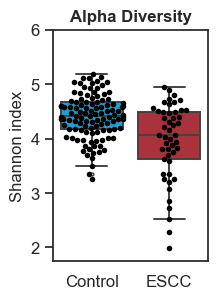

P value = 0.00020662024615608068


In [6]:
shannon_index = pd.DataFrame(data = rarefied_table.apply(sdi,axis=1),columns=["shannon"])
shannon_index["Cancer"] = [int("CESCC" in name) for name in shannon_index.index]

x = shannon_index["Cancer"].astype(str)
y = shannon_index["shannon"]


my_pal = {"0": "#00AEEF", "1": "#BE1E2D"}
sns.set_theme(style="white", palette=None)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(2, 3))
sns.boxplot(x=x,y=y,fliersize=2,linewidth=1.4, hue = x, palette=my_pal)
sns.swarmplot(x=x,y=y,color="black",s=4)
ax.set_ylabel("Shannon index")
ax.set_ylim(1.75,6)
ax.set_xlabel("")
ax.set_xticklabels(['Control', 'ESCC'], size=12)
ax.tick_params(labelsize=12,bottom=False)
ax.set_title("Alpha Diversity", size=12, fontweight='bold')

plt.show()

stat,p_value = stats.mannwhitneyu(shannon_index.loc[shannon_index["Cancer"] == 1,"shannon"],shannon_index.loc[shannon_index["Cancer"] == 0,"shannon"],alternative='two-sided')
print(f"P value = {p_value}")

## Fig 1b. Beta Diversity (Unweighted)

In [206]:
def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

In [207]:
unweighted_pcoa = pd.read_csv('diversity/unweighted_unifrac_pcoa_ordination.txt',sep='\t',skiprows=6,index_col=0)
unweighted_pcoa["Cancer"] = [int("CESCC" in name) for name in unweighted_pcoa.index]
unweighted_pctvar=pd.read_csv('diversity/unweighted_unifrac_pcoa_ordination.txt',sep='\t').iloc[3,:]

/var/folders/3_/1cj9ly452_bgpshkny7139pr0000gn/T/ipykernel_86783/3439744259.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pc1_percentage = float(unweighted_pctvar[0]) * 100
/var/folders/3_/1cj9ly452_bgpshkny7139pr0000gn/T/ipykernel_86783/3439744259.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pc2_percentage = float(unweighted_pctvar[1]) * 100


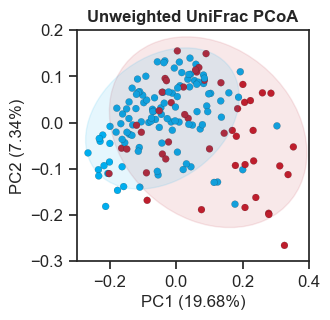

In [208]:
my_pal = {0: "#00AEEF", 1: "#BE1E2D"}
fig, ax = plt.subplots(figsize=(3, 3))

ax = sns.scatterplot(x="158", y="158.1", hue="Cancer", data=unweighted_pcoa, 
                     palette=my_pal, s=25, edgecolor='black',linewidth=0.1)
    
points_cancer_1 = unweighted_pcoa[unweighted_pcoa["Cancer"] == 1][["158", "158.1"]].values
e1 = plot_point_cov(points_cancer_1, nstd=2, ax=ax)
e1.set_facecolor((190/255, 30/255, 45/255, 0.1))
e1.set_edgecolor((190/255, 30/255, 45/255, 0.1))

points_cancer_0 = unweighted_pcoa[unweighted_pcoa["Cancer"] == 0][["158", "158.1"]].values
e2 = plot_point_cov(points_cancer_0, nstd=2, ax=ax)
e2.set_facecolor((0, 174/255, 239/255, 0.1))
e2.set_edgecolor((0, 174/255, 239/255, 0.1)) 

pc1_percentage = float(unweighted_pctvar[0]) * 100
pc2_percentage = float(unweighted_pctvar[1]) * 100

ax.set_xlabel(f"PC1 ({pc1_percentage:.2f}%)")
ax.set_ylabel(f"PC2 ({pc2_percentage:.2f}%)")

ax.set_ylim(-0.3, 0.20)
ax.set_xlim(-0.3, 0.40)

ax.set_title("Unweighted UniFrac PCoA", size=12, fontweight='bold')
ax.tick_params(labelsize=12)
ax.legend([], [], frameon=False)

plt.show()


## Supplementary Fig 1. Beta Diversity (Weighted) 

In [209]:
weighted_pcoa = pd.read_csv('diversity/weighted_unifrac_pcoa_ordination.txt',sep='\t',skiprows=6,index_col=0)
weighted_pcoa["Cancer"] = [int("CESCC" in name) for name in weighted_pcoa.index]
weighted_pctvar=pd.read_csv('diversity/weighted_unifrac_pcoa_ordination.txt',sep='\t').iloc[3,:]

/var/folders/3_/1cj9ly452_bgpshkny7139pr0000gn/T/ipykernel_86783/3916453876.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pc1_percentage = float(weighted_pctvar[0]) * 100
/var/folders/3_/1cj9ly452_bgpshkny7139pr0000gn/T/ipykernel_86783/3916453876.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pc2_percentage = float(weighted_pctvar[1]) * 100


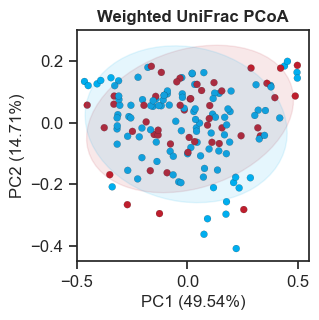

In [210]:
my_pal = {0: "#00AEEF", 1: "#BE1E2D"}
fig, ax = plt.subplots(figsize=(3, 3))

ax = sns.scatterplot(x="158", y="158.1", hue="Cancer", data=weighted_pcoa, 
                     palette=my_pal, s=25, edgecolor='black',linewidth=0.1)
    
points_cancer_1 = weighted_pcoa[weighted_pcoa["Cancer"] == 1][["158", "158.1"]].values
e1 = plot_point_cov(points_cancer_1, nstd=2, ax=ax)
e1.set_facecolor((190/255, 30/255, 45/255, 0.1))
e1.set_edgecolor((190/255, 30/255, 45/255, 0.1))

points_cancer_0 = weighted_pcoa[weighted_pcoa["Cancer"] == 0][["158", "158.1"]].values
e2 = plot_point_cov(points_cancer_0, nstd=2, ax=ax)
e2.set_facecolor((0, 174/255, 239/255, 0.1))
e2.set_edgecolor((0, 174/255, 239/255, 0.1)) 

pc1_percentage = float(weighted_pctvar[0]) * 100
pc2_percentage = float(weighted_pctvar[1]) * 100

ax.set_xlabel(f"PC1 ({pc1_percentage:.2f}%)")
ax.set_ylabel(f"PC2 ({pc2_percentage:.2f}%)")

ax.set_ylim(-0.45, 0.3)
ax.set_xlim(-0.5, 0.55)

ax.set_title("Weighted UniFrac PCoA", size=12, fontweight='bold')
ax.tick_params(labelsize=12)
ax.legend([], [], frameon=False)

plt.show()


# Differential abundance

## Fig 2a. Genus level differential abundance

In [102]:
corncob_batch_genus = pd.read_csv("corncob/corncob_results_batch_genus.csv",index_col=0) 
corncob_risk_genus = pd.read_csv("corncob/corncob_results_risk_genus.csv",index_col=0)

batch_genus_sig = corncob_batch_genus[corncob_batch_genus["p_fdr"] < 0.1].index
corncob_risk_genus_sig = corncob_risk_genus.loc[batch_genus_sig].dropna(axis = 0).drop("p_fdr",axis=1) 
corncob_risk_genus_sig["p_fdr"] = fdrcorrection(corncob_risk_genus_sig["Pr(>|t|)"],alpha=0.05)[1]
corncob_risk_batch_genus_adj = corncob_risk_genus_sig.sort_values(by='p_fdr')

genus_results = corncob_batch_genus[["Pr(>|t|)","p_fdr"]].dropna(axis=0).rename(columns={"Pr(>|t|)": 'p','p_fdr':'FDR'})
genus_results = genus_results.join(corncob_risk_genus['Pr(>|t|)']).rename(columns={'Pr(>|t|)':'adj_p'}).dropna(axis=0)
genus_results = genus_results.join(corncob_risk_batch_genus_adj['p_fdr']).rename(columns={'p_fdr':'adj_FDR'})
genus_results.sort_values(by='adj_FDR',inplace=True)

In [103]:
genus_results[genus_results["adj_FDR"] < 0.05]

,p,FDR,adj_p,adj_FDR
Genus,,,,
Capnocytophaga,0.000094,0.001417,0.000107,0.001071
Filifactor,0.000204,0.002372,0.000539,0.002697
Lautropia,0.008317,0.061596,0.001861,0.006204
Arachnia,0.001128,0.009360,0.008207,0.011724
Streptococcus,0.011603,0.078698,0.007809,0.011724
Bacteroides,0.000237,0.002372,0.006818,0.011724
Selenomonas,0.000020,0.000369,0.005362,0.011724
Leptotrichia,0.013659,0.080698,0.014739,0.018424
Campylobacter,0.006292,0.051604,0.031240,0.034711


In [72]:
genus_ra= feature_ra.T.join(taxonomy["Genus"],how='inner').set_index("Genus")
genus_ra = genus_ra.groupby(genus_ra.index).sum().T
genus_ra = genus_ra.div(genus_ra.sum(axis=1),axis=0)

In [ ]:
genus_carriage = []
for genus in genus_ra.columns: 
    ctrl_mask = genus_ra.index.str.contains('COOC')
    escc_mask = genus_ra.index.str.contains('CESCC')
    ctrl_carry = sum(genus_ra[genus][ctrl_mask] > 0) / sum(ctrl_mask) * 100
    escc_carry = sum(genus_ra[genus][escc_mask] > 0) / sum(escc_mask) * 100
    genus_carriage.append({"Genus": genus, "control_carriage": ctrl_carry, "escc_carriage": escc_carry})
genus_carriage = pd.DataFrame(genus_carriage).set_index('Genus')
genus_results = genus_results.join(genus_carriage)

/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 58.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


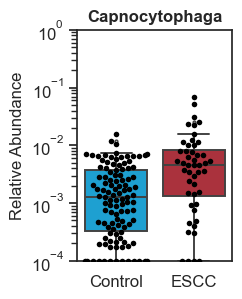

FDR-corrected p value = 0.001071077772823


/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 45.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


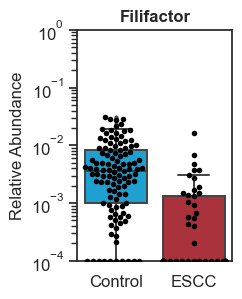

FDR-corrected p value = 0.002696991896985


/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 63.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 27.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 27.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 14.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.war

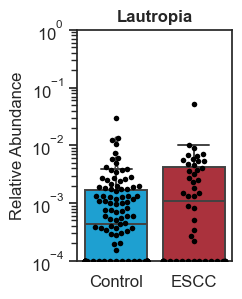

FDR-corrected p value = 0.006204450097993


/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 62.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 33.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 10.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.war

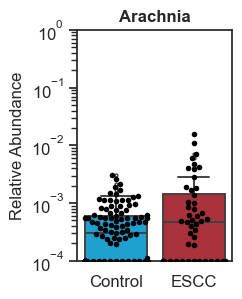

FDR-corrected p value = 0.011724163809521999


/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 24.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


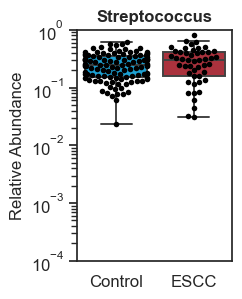

FDR-corrected p value = 0.011724163809521999


/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 52.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 64.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 17.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 41.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.war

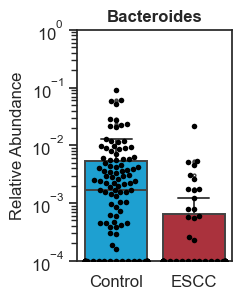

FDR-corrected p value = 0.011724163809521999


/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 32.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


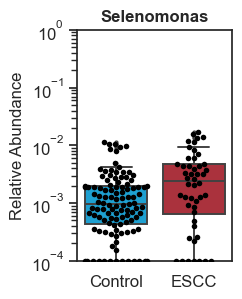

FDR-corrected p value = 0.011724163809521999


/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 22.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 8.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


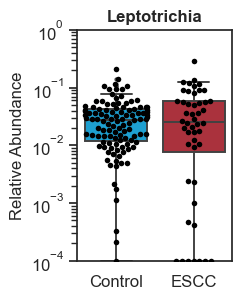

FDR-corrected p value = 0.018423977629950374


/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 15.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 5.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


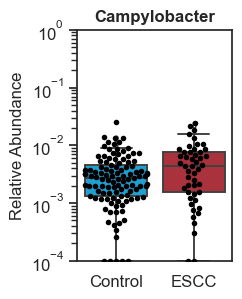

FDR-corrected p value = 0.034710740190358


In [114]:
for result in genus_results[genus_results["adj_FDR"] < 0.05].iterrows(): 
    genus = result[0]
    taxa_boxplot(genus_ra,genus,save=True)
    print(f"FDR-corrected p value = {result[1]["adj_FDR"]}")

In [ ]:
result_df = pd.DataFrame(index=genus_ra.columns)
shannon_pvals = [] # differences in shannon diversity between groups 
abundance_pvals = [] # differences in relative abundance between groups
shannon_abundance_corr = [] # correlations between shannon diversity and relative abundance 
n_cancer = []
n_control = []
for genus in genus_ra.columns: 
    asv = taxonomy[taxonomy["Genus"] == genus].index
    available_asv = asv.intersection(feature_table.columns)
    within_genus_table = feature_table[available_asv] 
    within_genus_table = within_genus_table.loc[within_genus_table.sum(axis=1) > 0] # keep only samples with more than a count of 0 in the genus 
    within_genus_ra = within_genus_table.div(within_genus_table.sum(axis=1),axis=0) 
    sample_ids = within_genus_ra.index
    cancer = np.array(["CESCC" in sample_id for sample_id in sample_ids])
    control = ~cancer
    rel_abundance = genus_ra[genus].loc[sample_ids]
    shannon = pd.DataFrame((within_genus_ra).apply(sdi,axis=1),columns = ["shannon"])
    n_cancer.append(len(shannon.iloc[cancer,:]["shannon"]))
    n_control.append(len(shannon.iloc[control,:]["shannon"]))
    if (len(shannon.iloc[cancer,:]["shannon"]) > 1) & (len(shannon.iloc[control,:]["shannon"]) > 1):
        stat, p_value_shannon = stats.mannwhitneyu(shannon.loc[cancer, "shannon"], shannon.loc[control, "shannon"], alternative='greater') # test if shannon diversity is greater  in cancer
        shannon_pvals.append(p_value_shannon)
        stat, p_value_abundance = stats.mannwhitneyu(rel_abundance.loc[cancer], rel_abundance.loc[control], alternative='two-sided') # test if relative abudnance is greater in cancer 
        abundance_pvals.append(p_value_abundance)
        spearman_corr = stats.spearmanr(shannon["shannon"],rel_abundance)
        shannon_abundance_corr.append(spearman_corr[0])
    else: 
        shannon_pvals.append(np.nan)
        abundance_pvals.append(np.nan)
        shannon_abundance_corr.append(np.nan)
result_df["shannon_pvals"] = shannon_pvals # tells you if the cancer microbiome is more diverse
result_df["abundance_pvals"] = abundance_pvals # tells you if relative abundance is greater in the cancer group 
result_df["shannon_abundance_corr"] = shannon_abundance_corr # tells you if relative abundance is correlated with shannon diversity
result_df["n_cancer"] = n_cancer
result_df["n_control"] = n_control

/var/folders/3_/1cj9ly452_bgpshkny7139pr0000gn/T/ipykernel_96426/1451207862.py:25: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = stats.spearmanr(shannon["shannon"],rel_abundance)
/var/folders/3_/1cj9ly452_bgpshkny7139pr0000gn/T/ipykernel_96426/1451207862.py:25: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = stats.spearmanr(shannon["shannon"],rel_abundance)
/var/folders/3_/1cj9ly452_bgpshkny7139pr0000gn/T/ipykernel_96426/1451207862.py:25: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = stats.spearmanr(shannon["shannon"],rel_abundance)
/var/folders/3_/1cj9ly452_bgpshkny7139pr0000gn/T/ipykernel_96426/1451207862.py:25: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr = stats.spearmanr(shannon["shannon"],rel_abundance)
/var/folders/3_/1cj9

In [35]:
genus_diversity_res = result_df.dropna()
genus_diversity_res["shannon_pvals_fdr"] = fdrcorrection(genus_diversity_res["shannon_pvals"],alpha=0.05)[1]
genus_diversity_res.sort_values(by='shannon_pvals')

/var/folders/3_/1cj9ly452_bgpshkny7139pr0000gn/T/ipykernel_96426/2018437626.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genus_diversity_res["shannon_pvals_fdr"] = fdrcorrection(genus_diversity_res["shannon_pvals"],alpha=0.05)[1]


,shannon_pvals,abundance_pvals,shannon_abundance_corr,n_cancer,n_control,shannon_pvals_fdr
Genus,,,,,,
Arachnia,0.032589,0.021065,0.292519,32,66,0.896482
Johnsonella,0.040173,0.024670,0.760585,10,54,0.896482
Ligilactobacillus,0.042856,0.142857,0.872872,2,6,0.896482
Peptoniphilaceae_[G-1],0.075765,0.388947,0.278076,7,41,0.896482
Bacteroidales_[G-2],0.095881,0.124630,0.552885,31,66,0.896482
...,...,...,...,...,...,...
Erysipelotrichaceae_[G-1],0.999981,0.049880,0.448308,42,108,1.000000
Rothia,0.999989,0.000823,0.144256,45,110,1.000000
Lachnospiraceae_[G-2],0.999996,0.820951,0.576681,42,109,1.000000


In [37]:
def plot_diversity_genus(genus): 
    if genus not in taxonomy["Genus"].values:
        print(f"Genus '{genus}' not found in taxonomy.")
        return
    asvs = taxonomy[taxonomy["Genus"] == genus].index
    within_genus_table = feature_table[asvs.intersection(feature_table.columns)]
    within_genus_table = within_genus_table.loc[within_genus_table.sum(axis=1) > 0]
    within_genus_ra = within_genus_table.div(within_genus_table.sum(axis=1),axis=0) 
    shannon = pd.DataFrame((within_genus_ra).apply(sdi,axis=1),columns = ["shannon"])
    sample_ids = within_genus_ra.index
    shannon["Cancer"] = [int("CESCC" in sample_id) for sample_id in sample_ids]
    my_pal = {0: "#00AEEF", 1: "#BE1E2D"}
    sns.set_theme(style="white", palette=None)
    sns.set_style("ticks")
    fig, ax = plt.subplots(figsize=(2, 3))
    sns.boxplot(x=shannon["Cancer"].astype(str), y=shannon["shannon"],hue = shannon["Cancer"], fliersize=2,linewidth=1.4,palette=my_pal,legend=False)
    sns.swarmplot(x=shannon["Cancer"].astype(str), y=shannon["shannon"],color="black",s=4)
    ax.set_ylabel("Shannon index")
    ax.set_xlabel("")
    ax.set_xticklabels(['Control', 'ESCC'], size=12)
    ax.tick_params(labelsize=12,bottom=False)
    ax.set_title(f"Alpha Diversity of {genus}", size=12, fontweight='bold')
    plt.show()

/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 72.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 40.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/var/folders/3_/1cj9ly452_bgpshkny7139pr0000gn/T/ipykernel_96426/1893778337.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Control', 'ESCC'], size=12)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 72.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warni

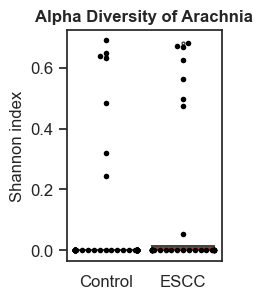

/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 30.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 10.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 33.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 10.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.war

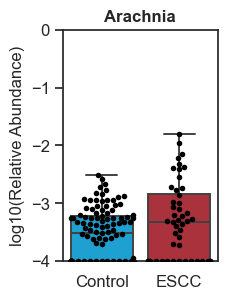

In [38]:
plot_diversity_genus("Arachnia")
taxa_boxplot(genus_ra,"Arachnia")

## Fig 2b. ASV level differential abundance

In [84]:
corncob_batch = pd.read_csv("corncob/corncob_results_batch.csv",index_col=0)
corncob_risk = pd.read_csv("corncob/corncob_results_risk.csv",index_col=0)

batch_sig = corncob_batch[corncob_batch["p_fdr"] < 0.1].index 
corncob_risk_sig = corncob_risk.loc[batch_sig].dropna(axis = 0).drop("p_fdr",axis=1) 
corncob_risk_sig["p_fdr"] = fdrcorrection(corncob_risk_sig["Pr(>|t|)"],alpha=0.05)[1]
corncob_risk_batch_adj = corncob_risk_sig.join(taxonomy[["Genus","Species"]]).sort_values(by='p_fdr')

asv_results = corncob_batch[["Pr(>|t|)","p_fdr"]].dropna(axis=0).rename(columns={"Pr(>|t|)": 'p','p_fdr':'FDR'})
asv_results = asv_results.join(corncob_risk['Pr(>|t|)']).rename(columns={'Pr(>|t|)':'adj_p'}).dropna(axis=0)
asv_results = asv_results.join(corncob_risk_batch_adj['p_fdr']).rename(columns={'p_fdr':'adj_FDR'})
asv_results.sort_values(by='adj_FDR',inplace=True)
asv_results = asv_results.join(taxonomy[["Genus","Species"]])

In [138]:
asv_results[asv_results["Genus"] == "Campylobacter"]

,p,FDR,adj_p,adj_FDR,Genus,Species,control_carriage,escc_carriage
ASV,,,,,,,,
ASV4637,0.141241,0.691678,0.350168,NaN,Campylobacter,showae,27.272727,27.083333
ASV8260,0.380644,0.909922,0.927156,NaN,Campylobacter,gracilis,48.181818,35.416667
ASV11151,0.898934,0.967784,0.447899,NaN,Campylobacter,concisus,29.090909,37.500000


In [87]:
asv_carriage = []
for asv in feature_ra.columns: 
    ctrl_mask = feature_ra.index.str.contains('COOC')
    escc_mask = feature_ra.index.str.contains('CESCC')
    ctrl_carry = sum(feature_ra[asv][ctrl_mask] > 0) / sum(ctrl_mask) * 100
    escc_carry = sum(feature_ra[asv][escc_mask] > 0) / sum(escc_mask) * 100
    asv_carriage.append({"ASV": asv, "control_carriage": ctrl_carry, "escc_carriage": escc_carry})
asv_carriage = pd.DataFrame(asv_carriage).set_index('ASV')

In [89]:
asv_results = asv_results.join(asv_carriage)

In [ ]:
porphyromonas_indices = taxonomy[taxonomy["Genus"] == "Porphyromonas"].index
common_indices = porphyromonas_indices.intersection(corncob_batch.index)
result = corncob_batch.loc[common_indices]

/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 84.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 66.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 72.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 60.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.war

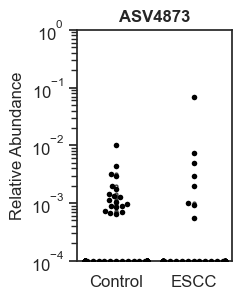

FDR-corrected p value = 5.9409999999999994e-08


/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 66.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 29.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 31.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 18.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.war

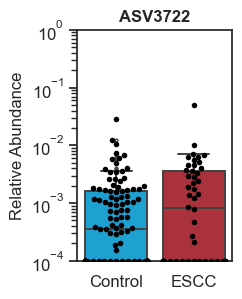

FDR-corrected p value = 0.007725090749999999


/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 52.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 19.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 18.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn

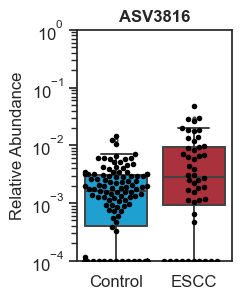

FDR-corrected p value = 0.007725090749999999


/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 78.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 64.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 58.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.war

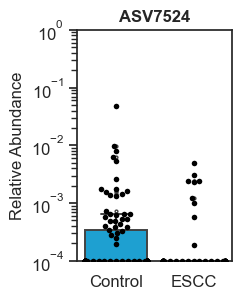

FDR-corrected p value = 0.007725090749999999


/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 61.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 14.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 39.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 14.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.war

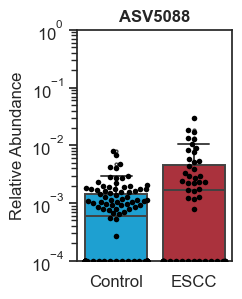

FDR-corrected p value = 0.028455801399999998


In [115]:
for result in asv_results[asv_results["adj_FDR"] < 0.05].iterrows(): 
    taxa = result[0]
    taxa_boxplot(feature_ra,taxa,True)
    print(f"FDR-corrected p value = {result[1]["adj_FDR"]}")

## Fig 2c. Fusobacterium differential abundance

In [6]:
corncob_batch = pd.read_csv("corncob/corncob_results_batch.csv",index_col=0)
corncob_risk = pd.read_csv("corncob/corncob_results_risk.csv",index_col=0)

batch_sig = corncob_batch[corncob_batch["p_fdr"] < 0.1].index 
corncob_risk_sig = corncob_risk.loc[batch_sig].dropna(axis = 0).drop("p_fdr",axis=1) 
corncob_risk_sig["p_fdr"] = fdrcorrection(corncob_risk_sig["Pr(>|t|)"],alpha=0.05)[1]
corncob_risk_batch_adj = corncob_risk_sig.join(taxonomy[["Genus","Species"]]).sort_values(by='p_fdr')

asv_results = corncob_batch[["Pr(>|t|)","p_fdr"]].dropna(axis=0).rename(columns={"Pr(>|t|)": 'p','p_fdr':'FDR'})
asv_results = asv_results.join(corncob_risk['Pr(>|t|)']).rename(columns={'Pr(>|t|)':'adj_p'}).dropna(axis=0)
asv_results = asv_results.join(corncob_risk_batch_adj['p_fdr']).rename(columns={'p_fdr':'adj_FDR'})
asv_results.sort_values(by='adj_FDR',inplace=True)
asv_results = asv_results.join(taxonomy[["Genus","Species"]])

In [7]:
corncob_batch_fuso = pd.read_csv("corncob/corncob_results_batch_fusobacterium.csv",index_col=0)
corncob_risk_fuso = pd.read_csv("corncob/corncob_results_risk_fusobacterium.csv",index_col=0)

batch_sig_fuso = corncob_batch_fuso[corncob_batch_fuso["p_fdr"] < 0.1].index # less stringent 
corncob_risk_sig_fuso = corncob_risk_fuso.loc[batch_sig_fuso].dropna(axis = 0).drop("p_fdr",axis=1) 
corncob_risk_sig_fuso["p_fdr"] = fdrcorrection(corncob_risk_sig_fuso["Pr(>|t|)"],alpha=0.05)[1]
corncob_risk_batch_adj_fuso = corncob_risk_sig_fuso.loc[corncob_risk_sig_fuso["p_fdr"] < 0.05,:].sort_values(by='p_fdr')

fuso_results = corncob_batch[["Pr(>|t|)","p_fdr"]].dropna(axis=0).rename(columns={"Pr(>|t|)": 'p','p_fdr':'FDR'})
fuso_results = fuso_results.join(corncob_risk_fuso['Pr(>|t|)']).rename(columns={'Pr(>|t|)':'adj_p'}).dropna(axis=0)
fuso_results = fuso_results.join(corncob_risk_batch_adj_fuso['p_fdr']).rename(columns={'p_fdr':'adj_FDR'})
fuso_results.sort_values(by='adj_FDR',inplace=True)
fuso_results = fuso_results.join(taxonomy[["Genus","Species"]])

In [5]:
fuso_ASVs = taxonomy[taxonomy["Genus"] == "Fusobacterium"].index.intersection(feature_ra_filtered.columns)
fuso_table = feature_ra[fuso_ASVs]
fuso_ra = fuso_table.div(fuso_table.sum(axis=1),axis=0)

/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 11.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 16.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 7.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


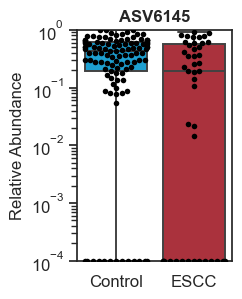

FDR-corrected p value = 0.0027995150000000002


/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 46.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/ENTER/envs/16S-analysis/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 38.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


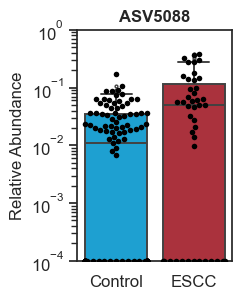

FDR-corrected p value = 0.0105096725


In [122]:
for result in fuso_results[fuso_results["adj_FDR"] < 0.05].iterrows(): 
    taxa = result[0]
    taxa_boxplot(fuso_ra,taxa,True)
    print(f"FDR-corrected p value = {result[1]["adj_FDR"]}")

In [13]:
# ratio analysis
microbes = fuso_ra.columns
unique_pairs = list(itertools.combinations(microbes, 2))
ratio_fuso = pd.DataFrame(index=fuso_ra.index)
for asv1, asv2 in unique_pairs:
    ratio_name = f"{asv1}/{asv2}"  # Create ratio column name
    ratio_fuso[ratio_name] = np.log(fuso_ra[asv1] / fuso_ra[asv2])
    ratio_fuso[ratio_name] = ratio_fuso[ratio_name].replace([np.inf, -np.inf], np.nan) 
cancer = ratio_fuso.index.str.contains('CESCC')
associations = pd.DataFrame(index = ratio_fuso.columns)
pvals = []
for ASV in ratio_fuso.columns:
    if (len(ratio_fuso[ASV][cancer].dropna()) > 4) and (len(ratio_fuso[ASV][~cancer].dropna()) > 4): 
        stat,p_value = stats.mannwhitneyu(ratio_fuso[ASV][cancer].dropna(),ratio_fuso[ASV][~cancer].dropna(),alternative='two-sided') #alternative='greater'
        pvals.append(p_value)
    else: 
        pvals.append(np.nan)
associations["p_vals"] = pvals
associations = associations.dropna(axis=0)
associations['p_vals_fdr'] = fdrcorrection(associations["p_vals"],alpha=0.05)[1]

/Users/shahdelnaggar/miniconda3/envs/pp3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/shahdelnaggar/miniconda3/envs/pp3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/shahdelnaggar/miniconda3/envs/pp3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/shahdelnaggar/miniconda3/envs/pp3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/shahdelnaggar/miniconda3/envs/pp3/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inp

In [14]:
associations.sort_values(by='p_vals_fdr')

,p_vals,p_vals_fdr
ASV10567/ASV10810,0.004329,0.096987
ASV6145/ASV10810,0.002313,0.096987
ASV3607/ASV10810,0.003108,0.096987
ASV5088/ASV10567,0.005060,0.096987
ASV1585/ASV5088,0.006450,0.096987
...,...,...
ASV3926/ASV4911,0.832945,1.000000
ASV3012/ASV5088,0.954645,1.000000
ASV1585/ASV3926,0.909049,1.000000
ASV3611/ASV6145,0.880976,1.000000


/Users/shahdelnaggar/miniconda3/envs/pp3/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 78.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/miniconda3/envs/pp3/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 41.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/miniconda3/envs/pp3/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 78.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/shahdelnaggar/miniconda3/envs/pp3/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 41.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarni

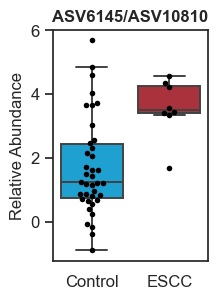

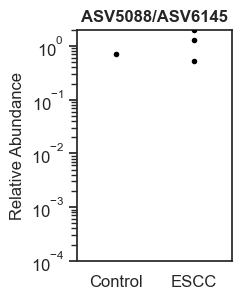

In [21]:
taxa_boxplot(ratio_fuso,'ASV6145/ASV10810')
taxa_boxplot(ratio_fuso,'ASV5088/ASV6145',False,True)

# Predictive models 

In [90]:
# AUC comparison adapted from
# https://github.com/Netflix/vmaf/

def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=np.float64)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=np.float64)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2

def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=np.float64)
    ty = np.empty([k, n], dtype=np.float64)
    tz = np.empty([k, m + n], dtype=np.float64)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov

def delong_roc_test(ground_truth, predictions_one, predictions_two):
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    
    # Using float or np.float64 instead of np.float
    tx = np.empty([2, label_1_count], dtype=np.float64)
    ty = np.empty([2, len(ground_truth) - label_1_count], dtype=np.float64)
    tz = np.empty([2, len(ground_truth)], dtype=np.float64)
    
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)

## Fig 3a. Validation of predictors on held-out samples 

In [51]:
microbiome_nested_predictions = pd.read_csv("predictions/microbiome_nested_res.csv",index_col=0)
clinical_nested_predictions = pd.read_csv("predictions/clinical_nested_res.csv",index_col=0)
mb_clinical_nested_res = pd.read_csv("predictions/microbiome_clinical_nested_res.csv",index_col=0)
genus_nested_res = pd.read_csv("predictions/genus_nested_res.csv",index_col=0)

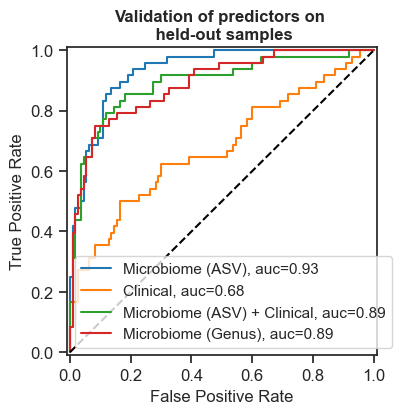

In [59]:
sns.set_theme(style="white", palette=None)
sns.set_theme(style="white", palette=None)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(4, 4))

models = [microbiome_nested_predictions, clinical_nested_predictions, mb_clinical_nested_res,genus_nested_res]
labels = ["Microbiome (ASV)", "Clinical", "Microbiome (ASV) + Clinical","Microbiome (Genus)"]
for model, label in zip(models,labels): 
    fpr, tpr, thresh = metrics.roc_curve(model['y_test'], model['y_pred'])
    auc = metrics.roc_auc_score(model['y_test'], model['y_pred'])
    plt.plot(fpr, tpr, label=f"{label}, auc={auc:.2f}")

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Validation of predictors on \n held-out samples',size=12, fontweight='bold')

ax.set_xlim(-0.01, 1.01)
ax.set_ylim(-0.01, 1.01)
ax.tick_params(labelsize=12)

plt.plot([0, 1], [0, 1],'k--')
plt.legend(loc=0)
plt.savefig('figures/auroc.svg')

In [ ]:
# run delong tests
ground_truth = nested_res["y_test"]
log_p_value = delong_roc_test(np.array(ground_truth), np.array(nested_res_1["y_pred"]), np.array(nested_res_2["y_pred"]))
print(f"log(p-value): {log_p_value}")
10**log_p_value

## Fig 3c. Validation of microbiome predictor on external cohort 

In [110]:
# wang feature table
# table_wang = pd.read_csv("/Users/shahdelnaggar/Desktop/korem-lab/south-africa-ESCC/validation/tables-crossval/wang-genus-table-crossval-full16S.csv",header=0,index_col=0)